In [1]:
import monai
import pandas as pd
import numpy as np
import os
import json
from monai.config.type_definitions import NdarrayOrTensor
from monai.config import DtypeLike
from monai.data.meta_obj import get_track_meta
from monai.utils.type_conversion import convert_data_type, convert_to_tensor
from monai.transforms.transform import  MapTransform
from monai.data.meta_obj import get_track_meta
from typing import Callable, Hashable, Mapping, Sequence
from monai.config import DtypeLike, KeysCollection
import torch

from radiomics.featureextractor import RadiomicsFeatureExtractor 

exposure, has_skimage = monai.utils.optional_import("skimage.exposure")

 missing cuda symbols while dynamic loading
 cuFile initialization failed


In [2]:
def calculate_image_histogram(img: np.ndarray, mask: np.ndarray | None = None, num_bins: int = 256):
    
    hist_img = img[np.array(mask, dtype=bool)] if mask is not None else img
    if has_skimage:
        hist, bins = exposure.histogram(hist_img.flatten(), num_bins)
    else:
        hist, bins = np.histogram(hist_img.flatten(), num_bins)
        bins = (bins[:-1] + bins[1:]) / 2
    return hist, bins

In [3]:
class ComputeHistogramd(MapTransform):
    """
    Args:
        num_bins: number of the bins to use in histogram, default to `256`. for more details:
            https://numpy.org/doc/stable/reference/generated/numpy.histogram.html.
        min: the min value to normalize input image, default to `0`.
        max: the max value to normalize input image, default to `255`.
        mask: if provided, must be ndarray of bools or 0s and 1s, and same shape as `image`.
            only points at which `mask==True` are used for the equalization.
            can also provide the mask along with img at runtime.
        dtype: data type of the output, if None, same as input image. default to `float32`.

    """

    def __init__(
        self,
        keys: KeysCollection,
        num_bins: int = 256,
        min: int = 0,
        max: int = 255,
        mask: NdarrayOrTensor | None = None,
        mask_key: str | None = None,
        dtype: DtypeLike = np.float32,
        allow_missing_keys: bool = False,
    ) -> None:
        
        super().__init__(keys, allow_missing_keys)
        self.num_bins = num_bins
        self.min = min
        self.max = max
        self.mask = mask
        self.dtype = dtype
        self.mask_key = mask_key if mask is None else None

    def __call__(self, data: Mapping[Hashable, NdarrayOrTensor]) -> dict[Hashable, NdarrayOrTensor]:
        d = dict(data)
        for key in self.key_iterator(d):
            img = d[key]
            mask = d[self.mask_key] if self.mask_key is not None else None
            img = convert_to_tensor(img, track_meta=get_track_meta())
            img_np, *_ = convert_data_type(img, np.ndarray)
            mask_np: np.ndarray | None = None
            if mask is not None:
                mask_np, *_ = convert_data_type(mask, np.ndarray)

            hist,bins = calculate_image_histogram(img=img_np, mask=mask_np, num_bins=self.num_bins)
            d[f'{key}_hist'] = hist
            d[f'{key}_bins'] = bins
        

        return d

In [4]:
path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021"
derivatives_path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021/derivatives/creating_adc"
t2_list = []
adc_list = []
dwi_list = []

# Creating a list of all the files in the directory starting with sub-*
subjects = [f for f in os.listdir(path) if f.startswith("sub-")]
derivatives_subs = [f for f in os.listdir(derivatives_path) if f.startswith("sub-")]

for sub in subjects:
    derivative_sessions=None
    if sub in derivatives_subs:
        derivative_sessions = [f for f in os.listdir(os.path.join(derivatives_path, sub)) if f.startswith("ses-")]
    sessions = [f for f in os.listdir(os.path.join(path, sub)) if f.startswith("ses-")]
    for ses in sessions:
        # Check if the anat and dwi paths exist
        anat_path = os.path.join(path, sub, ses,'mim-mr','anat')
        dwi_path = os.path.join(path, sub, ses,'mim-mr','dwi')

        if os.path.exists(anat_path):
            images_anat = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz")]
            for img in images_anat:
                if 'T2w' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','anat', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'T2w'}
                    img_dict.update(data)
                    t2_list.append(img_dict)
        if os.path.exists(dwi_path):
            images_dwi = [f for f in os.listdir(dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                if 'bvalue' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'dwi'}
                    img_dict.update(data)
                    dwi_list.append(img_dict)
                elif 'adc' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                    img_dict.update(data)
                    adc_list.append(img_dict)
    if derivative_sessions:
        for ses in derivative_sessions:
            der_dwi_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi')
            images_dwi = [f for f in os.listdir(der_dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                json_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                with open(json_path) as f:
                    data = json.load(f)
                #Add json data to the dict image
                img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'derivatives-adc'}
                img_dict.update(data)
                adc_list.append(img_dict)


t2w_df = pd.DataFrame(t2_list)
dwi_df = pd.DataFrame(dwi_list)
adc_df = pd.DataFrame(adc_list)


In [5]:
t2w_df

,subject,session,image,modality,AccessionNumber,AcquisitionDate,AcquisitionMatrix,AcquisitionNumber,AcquisitionTime,AngioFlag,...,BurnedInAnnotation,LossyImageCompression,NumberOfStudyRelatedInstances,PatientIdentityRemoved,SequenceName,TransmitCoilName,TemporalResolution,PixelPaddingValue,ContentQualification,ContrastBolusRoute
0,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-3_bp-prostat...,T2w,000063,20160707,"[0, 320, 256, 0]",1,145247,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-8_bp-prostat...,T2w,000063,20160707,"[320, 0, 0, 224]",1,151334,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,sub-000063,ses-000063,sub-000063_ses-000063_acq-fse_run-6_bp-prostat...,T2w,000063,20160707,"[320, 0, 0, 224]",1,150232,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-3_bp-prostat...,T2w,000066,20170127,"[0, 320, 224, 0]",1,152652,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,sub-000066,ses-000066,sub-000066_ses-000066_acq-fse_run-5_bp-prostat...,T2w,000066,20170127,"[0, 320, 256, 0]",1,153336,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
543,sub-000003,ses-000003,sub-000003_ses-000003_acq-fse_run-8_bp-arm_vp-...,T2w,000003,20140307,"[0, 320, 256, 0]",1,082739,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
544,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-5_bp-abdomen...,T2w,000111,20150624,"[0, 320, 256, 0]",1,194350,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
545,sub-000111,ses-000111,sub-000111_ses-000111_acq-fse_run-8_bp-abdomen...,T2w,000111,20150624,"[320, 0, 0, 224]",1,195541,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
546,sub-000120,ses-000120,sub-000120_ses-000120_acq-fse_run-8_bp-abdomen...,T2w,000120,20140924,"[320, 0, 0, 224]",1,081911,N,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
images_paths = t2w_df.copy().apply(lambda x: os.path.join(path, x['subject'], x['session'],'mim-mr','anat', x['image']), axis=1)

In [7]:

# Divide into axial, coronal and sagital images
data_list = []
for path in images_paths.values:
    files = {}
    image_name = path.split('/')[-1]
    files['image'] = path        
    data_list.append(files)

transforms = monai.transforms.Compose(
            [
                monai.transforms.LoadImaged(keys=["image"],allow_missing_keys=True,image_only=False),
                #monai.transforms.ScaleIntensityd(keys=["image"]),
                ComputeHistogramd(keys=["image"], mask_key=None, num_bins=50, min=0, max=255, dtype=np.float32, allow_missing_keys=True)
                ]
)

train_ds = monai.data.Dataset(
    data=data_list,
    transform=transforms,
)

In [45]:
train_ds[0]

{'image': metatensor([[[ 0.,  0.,  0.,  ...,  2.,  2.,  2.],
          [ 3.,  5.,  8.,  ...,  6.,  8., 12.],
          [12., 12., 13.,  ...,  6., 10., 12.],
          ...,
          [ 0.,  0.,  0.,  ...,  3.,  3.,  1.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  3.,  4.,  2.],
          [ 3.,  4., 10.,  ...,  6., 11., 11.],
          [11.,  9., 15.,  ...,  8., 13., 11.],
          ...,
          [ 0.,  0.,  0.,  ...,  3.,  3.,  2.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         [[ 0.,  0.,  0.,  ...,  3.,  4.,  2.],
          [ 3.,  5.,  9.,  ...,  7., 11., 10.],
          [11., 14., 16.,  ..., 14., 16., 14.],
          ...,
          [ 0.,  0.,  1.,  ...,  6.,  8.,  5.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  ...,  0.,  0.,  0.]],
 
         ...,
 
         [[ 0.,  0.,  0.,  ...,  0.,  0.,  0.],
     

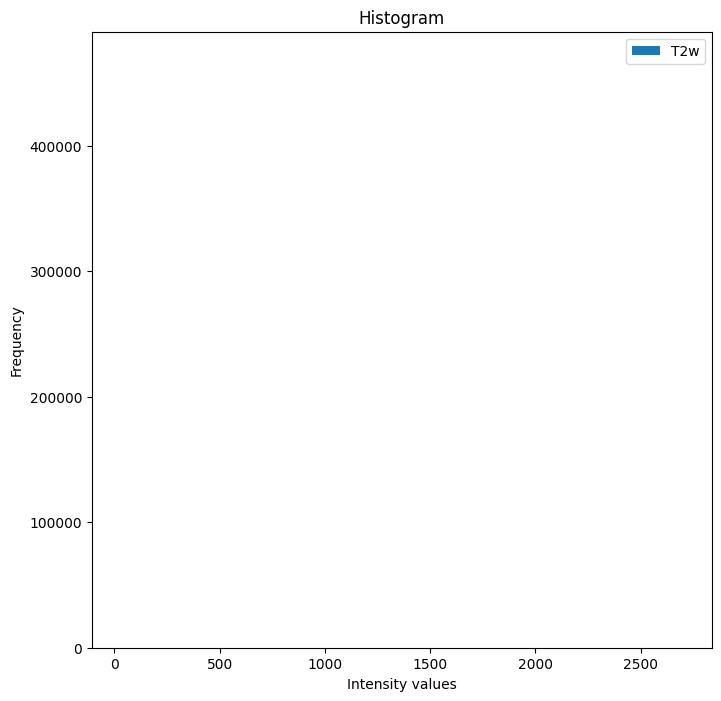

In [46]:
#plotting the histogram
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.bar(train_ds[0]['image_bins'], train_ds[0]['image_hist'], label='T2w')
ax.set_title('Histogram')
ax.set_xlabel('Intensity values')
ax.set_ylabel('Frequency')
ax.legend()
plt.show()


## Get Radiomic Features

In [4]:
import SimpleITK as sitk
import matplotlib.pyplot as plt
from numpy import std,mean

In [8]:
data_list = []
for path in images_paths.values:
    files = {}
    image_name = path.split('/')[-1]
    files['image'] = path        
    data_list.append(files)


In [14]:
def delete_black_slices(image: sitk.Image, threshold: float = 0.5):
    #image = sitk.ReadImage(image_path)
    
    data = sitk.GetArrayFromImage(image)
    img_std = std(data, keepdims=False)
    std_per_slice_axis1 = std(data, axis=(1, 2), keepdims=False)
    std_per_slice_axis2 = std(data, axis=(0, 2), keepdims=False)
    std_per_slice_axis3 = std(data, axis=(0, 1), keepdims=False)

    img_mean = mean(data, keepdims=False)
    mean_per_slice_axis1 = mean(data, axis=(1, 2), keepdims=False)
    mean_per_slice_axis2 = mean(data, axis=(0, 2), keepdims=False)
    mean_per_slice_axis3 = mean(data, axis=(0, 1), keepdims=False)

    mask_axis1 = (std_per_slice_axis1 > threshold * img_std) & (mean_per_slice_axis1 > threshold * img_mean)
    mask_axis2 = (std_per_slice_axis2 > threshold * img_std) & (mean_per_slice_axis2 > threshold * img_mean)
    mask_axis3 = (std_per_slice_axis3 > threshold * img_std) & (mean_per_slice_axis3 > threshold * img_mean)

    mask = np.full(data.shape, False)

    mask[np.ix_(mask_axis1, mask_axis2, mask_axis3)] = True
    # mask[mask_axis1, mask, :] = True
    # mask[:,mask_axis2,:] = True
    # mask[:,:,mask_axis3] = True
    masked_image = data[mask_axis1, :, :]
    masked_image = data[:, mask_axis2, :]
    masked_image = data[:, :, mask_axis3]
    
    
    #convert mask to simpleitk image
    mask = sitk.GetImageFromArray(mask.astype(np.uint8))
    mask.CopyInformation(image)

    #sitk.WriteImage(mask, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz")
    return mask, masked_image


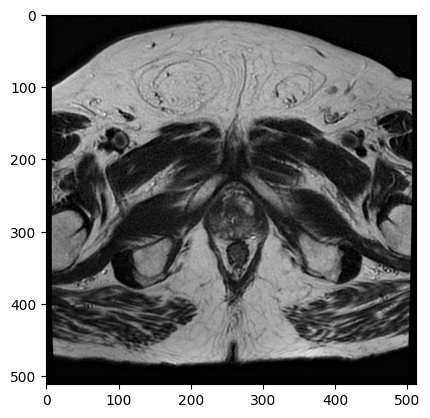

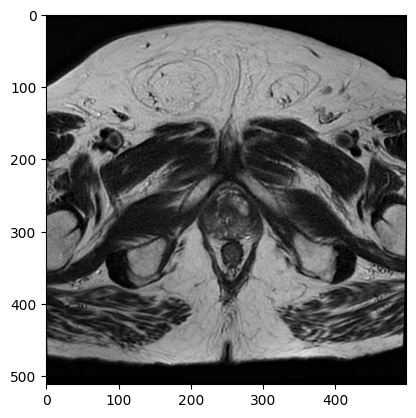

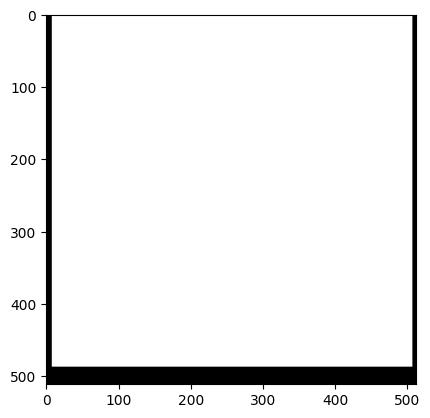

In [11]:
# Read Image using SimpleITK


image = sitk.ReadImage(images_paths[107])

#plot the image
plt.imshow(sitk.GetArrayFromImage(image)[5,:,:], cmap='gray')
plt.show()

#Apply tresholding to delete black zones with SimpleITK filters
mask, filtered_image = delete_black_slices(image, threshold=0.2)

plt.imshow(filtered_image[5,:,:], cmap='gray')
plt.show()

#plot the mask
plt.imshow(sitk.GetArrayFromImage(mask)[5,:,:], cmap='gray')
plt.show()

#save mask as temporal file
#sitk.WriteImage(mask, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_mask.nii.gz")

#save image as temporal file
#sitk.WriteImage(image, "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/tmp_mask_radiomics/tmp_image.nii.gz")



In [12]:
#Extracting radiomics features
extractor = RadiomicsFeatureExtractor()

features = extractor.execute(image, mask)
features

GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.3'),
             ('diagnostics_Versions_SimpleITK', '2.3.1'),
             ('diagnostics_Versions_PyWavelet', '1.6.0'),
             ('diagnostics_Versions_Python', '3.10.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diag

In [48]:
import logging  # to track running
import os  # help us load files and deal with paths
from multiprocessing import cpu_count, Pool
import threading
import pandas as pd  # for reading and writing tables
import SimpleITK as sitk
import radiomics  # radiomics package
from radiomics import featureextractor
import numpy as np
import pandas as pd


from pathlib import Path

In [49]:
def calculate_radiomics(case): 
    settings = {}
    settings["binWidth"] = 25
    settings["resampledPixelSpacing"] = None
    settings["interpolator"] = sitk.sitkBSpline
    settings["enableCExtensions"] = True
    extractor = featureextractor.RadiomicsFeatureExtractor(**settings)

    print(
        f"Processing Patient {case['ID']} (Image: {case['Image']}, Mask: {case['Mask']})"
    )

    image_path = case["Image"]
    image = sitk.ReadImage(image_path)

    mask,masked_image = delete_black_slices(image, threshold=0.2)

    values = np.unique(sitk.GetArrayFromImage(mask))
    # Uncomment if you want to check the number and values of all labels in the mask
    # print(values)
    values = np.array([1])  # Specify the values of labels of interest
    # Uncomment if you want to analyse all labels of mask
    # values = np.delete(values, 0)
    patient = pd.Series()
    patient.name = case["ID"]
    for label in values:
        label = int(label)
        print(
            f"Processing Patient {case['ID']} (Image: {case['Image']}, Mask: {mask}, Label: {label})"
        )
        if (image is not None) and (mask is not None):
            try:
                result = pd.Series(extractor.execute(image, mask, label))
            except Exception as e:
                print("FEATURE EXTRACTION FAILED:", str(e))
                result = pd.Series()
        else:
            print("FEATURE EXTRACTION FAILED: Missing Image and/or Mask")
            result = pd.Series()

        result.name = case["ID"]
        result = result.add_prefix(f"label{label}_")
        patient = patient.append(result)

    return patient

In [50]:
data = pd.DataFrame(columns=["ID", "Image"])
data["ID"] = t2w_df["subject"] + "_" + t2w_df["session"] + "_" + t2w_df["image"]
data["Image"] = images_paths.values

In [51]:
data

,ID,Image
0,sub-000063_ses-000063_sub-000063_ses-000063_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
1,sub-000063_ses-000063_sub-000063_ses-000063_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
2,sub-000063_ses-000063_sub-000063_ses-000063_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
3,sub-000066_ses-000066_sub-000066_ses-000066_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
4,sub-000066_ses-000066_sub-000066_ses-000066_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
...,...,...
543,sub-000003_ses-000003_sub-000003_ses-000003_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
544,sub-000111_ses-000111_sub-000111_ses-000111_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
545,sub-000111_ses-000111_sub-000111_ses-000111_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...
546,sub-000120_ses-000120_sub-000120_ses-000120_ac...,/mnt/ceib/datalake/FISABIO_datalake/prueba/p00...


In [52]:
outPath = "Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/"
## Rename following files with the selected masks
outputFilepath = os.path.join(outPath, "Picai_val_radiomics_features_t2w.csv")
outputSummary = os.path.join(outPath, "Picai_val_radiomics_summary_t2w.csv")
progress_filename = os.path.join(outPath, "Picai_val_radiomics_log_t2w.txt")
params = os.path.join(outPath, "Params.yaml")

In [54]:
# Assuming 'radiomics' and 'rLogger' are already imported and configured elsewhere in your code.
print("pyradiomics version:", radiomics.__version__)
print("Loading CSV")

try:
    # Use pandas to read and transpose ('.T') the input data
    # The transposition is needed so that each column represents one test case
    # This is easier for iteration over the input cases.
    flists = data.T
except Exception as e:
    print("CSV READ FAILED:", str(e))
print("Loading Done")
print("Patients:", len(flists.columns))

col_list = []
for col in flists:
    col_list.append(flists[col])

pool = Pool(processes=(cpu_count() - 1))
l_results = pool.map(calculate_radiomics, col_list)
pool.close()
pool.join()
# Merge results in one df
results = pd.DataFrame()
for result in l_results:
    results = results.join(result, how="outer")
# General info and features in two files
# Creating an only-features CSV makes R loading easier
results = results.T
info = results.filter(regex="general", axis=1).columns
print(info)
summary = results[info]
results = results.drop(info, axis=1)

print("Extraction complete, writing CSVs")

results.to_csv(outputFilepath, na_rep="NaN")
print("Features CSV writing complete")
summary.to_csv(outputSummary, na_rep="NaN")
print("Summary CSV writing complete")

pyradiomics version: v3.0.1
Loading CSV
Loading Done
Patients: 548


TypeError: 'module' object is not callable

In [24]:
# Print the number of features extracted
print(f"Number of features extracted: {len(features)}")

Number of features extracted: 129


In [25]:
features

OrderedDict([('diagnostics_Versions_PyRadiomics', 'v3.0.1'),
             ('diagnostics_Versions_Numpy', '1.26.3'),
             ('diagnostics_Versions_SimpleITK', '2.3.1'),
             ('diagnostics_Versions_PyWavelet', '1.6.0'),
             ('diagnostics_Versions_Python', '3.10.13'),
             ('diagnostics_Configuration_Settings',
              {'minimumROIDimensions': 2,
               'minimumROISize': None,
               'normalize': False,
               'normalizeScale': 1,
               'removeOutliers': None,
               'resampledPixelSpacing': None,
               'interpolator': 'sitkBSpline',
               'preCrop': False,
               'padDistance': 5,
               'distances': [1],
               'force2D': False,
               'force2Ddimension': 0,
               'resegmentRange': None,
               'label': 1,
               'additionalInfo': True}),
             ('diagnostics_Configuration_EnabledImageTypes', {'Original': {}}),
             ('diag

## Setting up Table 

In [87]:
import pandas as pd
import numpy as np
import os
import json

In [88]:
#read Table with the features
features = pd.read_csv("Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/results_T2w_train.csv")


In [89]:
#Save in a variabble numeric features
numeric_features = features.copy().select_dtypes(include=[np.number])
#Keep only the features which name contains 'original'
#numeric_features = numeric_features[numeric_features.columns[pd.Series(numeric_features.columns).str.contains('original')]]
# Add to numeric features the Unaamed column
numeric_features['instance'] = features['Unnamed: 0']

# delete 'label_1_' from feature names
numeric_features.columns = numeric_features.columns.str.replace('label1_', '') 





In [90]:
numeric_features

,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,diagnostics_Mask-interpolated_VoxelNum,diagnostics_Mask-interpolated_VolumeNum,...,original_glszm_SmallAreaLowGrayLevelEmphasis,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,instance
0,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,16821000.0,1.0,...,0.143118,5.828096,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06,sub-003950_ses-006079_sub-003950_ses-006079_ac...
1,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,24750000.0,1.0,...,0.091964,6.677913,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07,sub-003950_ses-006079_sub-003950_ses-006079_ac...
2,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,2806020.0,1.0,...,0.299920,4.197181,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06,sub-003950_ses-006328_sub-003950_ses-006328_ac...
3,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,2968896.0,1.0,...,0.270635,4.455283,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06,sub-003950_ses-006328_sub-003950_ses-006328_ac...
4,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,2938068.0,1.0,...,0.278429,4.351684,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06,sub-003950_ses-006328_sub-003950_ses-006328_ac...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32109,1542.441939,0.0,4979.0,6193536.0,1.0,0.000128,-2.038387,3.941289,3695354.0,1.0,...,0.259715,4.307560,0.000535,3.398477e+09,356651.604803,4.211401e-06,0.128513,0.031729,4.211509e-06,sub-003671_ses-006159_sub-003671_ses-006159_ac...
32110,1542.761783,0.0,5436.0,7693888.0,1.0,0.049647,-1.797537,3.769807,4703424.0,1.0,...,0.283520,4.450851,0.000658,3.530889e+09,259149.563737,3.988383e-06,0.106615,0.026650,3.988425e-06,sub-003671_ses-006159_sub-003671_ses-006159_ac...
32111,879.734623,0.0,7261.0,5713890.0,1.0,0.708992,-1.035303,5.334281,25502148.0,1.0,...,0.147187,5.799960,0.000193,7.940816e+10,217293.406147,1.815199e-06,0.043205,0.007976,1.814266e-06,sub-003671_ses-006159_sub-003671_ses-006159_ac...
32112,1778.216492,0.0,6097.0,6030336.0,1.0,0.113093,-2.007433,3.544728,4106400.0,1.0,...,0.201812,4.906415,0.000366,5.614818e+09,171840.480838,4.417391e-06,0.110256,0.027262,4.416389e-06,sub-003671_ses-006159_sub-003671_ses-006159_ac...


In [ ]:
path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021"
derivatives_path = "/mnt/ceib/datalake/FISABIO_datalake/prueba/p0042021/derivatives/creating_adc"
t2_list = []
adc_list = []
dwi_list = []

# Creating a list of all the files in the directory starting with sub-*
subjects = [f for f in os.listdir(path) if f.startswith("sub-")]
derivatives_subs = [f for f in os.listdir(derivatives_path) if f.startswith("sub-")]


for sub in subjects:
    derivative_sessions=None
    if sub in derivatives_subs:
        derivative_sessions = [f for f in os.listdir(os.path.join(derivatives_path, sub)) if f.startswith("ses-")]
    sessions = [f for f in os.listdir(os.path.join(path, sub)) if f.startswith("ses-")]
    for ses in sessions:
        # Check if the anat and dwi paths exist
        anat_path = os.path.join(path, sub, ses,'mim-mr','anat')
        dwi_path = os.path.join(path, sub, ses,'mim-mr','dwi')

        if os.path.exists(anat_path):
            images_anat = [f for f in os.listdir(anat_path) if f.endswith(".nii.gz")]
            for img in images_anat:
                if 'T2w' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','anat', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'T2w'}
                    img_dict.update(data)
                    t2_list.append(img_dict)
        if os.path.exists(dwi_path):
            images_dwi = [f for f in os.listdir(dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                if 'bvalue' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'dwi'}
                    img_dict.update(data)
                    dwi_list.append(img_dict)
                elif 'adc' in img and 'chunk' not in img:
                    json_path = os.path.join(path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                    with open(json_path) as f:
                        data = json.load(f)
                    #Add json data to the dict image
                    img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'adc'}
                    img_dict.update(data)
                    adc_list.append(img_dict)
    if derivative_sessions:
        for ses in derivative_sessions:
            der_dwi_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi')
            images_dwi = [f for f in os.listdir(der_dwi_path) if f.endswith(".nii.gz")]
            for img in images_dwi:
                json_path = os.path.join(derivatives_path, sub, ses,'mim-mr','dwi', img.replace('.nii.gz', '.json'))
                with open(json_path) as f:
                    data = json.load(f)
                #Add json data to the dict image
                img_dict = {'subject': sub, 'session': ses, 'image': img, 'modality': 'derivatives-adc'}
                img_dict.update(data)
                adc_list.append(img_dict)


t2w_df = pd.DataFrame(t2_list)
dwi_df = pd.DataFrame(dwi_list)
adc_df = pd.DataFrame(adc_list)

In [91]:
t2w_df = pd.read_csv("/home/jaalzate/Prostate_Cancer_TFM/Data_Analysis/Tables/Train_t2w_df.csv")

In [92]:
t2w_df.columns

Index(['subject', 'session', 'image', 'modality', 'AccessionNumber',
       'AcquisitionDate', 'AcquisitionDuration', 'AcquisitionMatrix',
       'AcquisitionNumber', 'AcquisitionTime',
       ...
       'PixelAspectRatio', 'AcquisitionDateTime', 'BurnedInAnnotation',
       'PatientIdentityRemoved', 'PixelPaddingValue', 'ContentQualification',
       'ContrastBolusVolume', 'WindowCenterWidthExplanation',
       'TimeOfLastCalibration', 'PlanarConfiguration'],
      dtype='object', length=131)

In [93]:
clinical_variables = pd.read_csv('/home/jaalzate/Prostate_Cancer_TFM/Files/Own_data/Clinical_Variables.tsv', sep='\t')

In [94]:
numeric_features["instance"][0]

'sub-003950_ses-006079_sub-003950_ses-006079_acq-fse_run-4_bp-prostate_vp-ax_T2w.nii.gz'

In [95]:
t2w_df['subject']+"_"+t2w_df['session']+"_"+t2w_df['image']

0        sub-003629_ses-003863_sub-003629_ses-003863_ac...
1        sub-003629_ses-003863_sub-003629_ses-003863_ac...
2        sub-003629_ses-003863_sub-003629_ses-003863_ac...
3        sub-003629_ses-003863_sub-003629_ses-003863_ac...
4        sub-005730_ses-006206_sub-005730_ses-006206_ac...
                               ...                        
32109    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32110    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32111    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32112    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32113    sub-003671_ses-004794_sub-003671_ses-004794_ac...
Length: 32114, dtype: object

In [96]:
numeric_features['instance']

0        sub-003950_ses-006079_sub-003950_ses-006079_ac...
1        sub-003950_ses-006079_sub-003950_ses-006079_ac...
2        sub-003950_ses-006328_sub-003950_ses-006328_ac...
3        sub-003950_ses-006328_sub-003950_ses-006328_ac...
4        sub-003950_ses-006328_sub-003950_ses-006328_ac...
                               ...                        
32109    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32110    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32111    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32112    sub-003671_ses-006159_sub-003671_ses-006159_ac...
32113    sub-003671_ses-004794_sub-003671_ses-004794_ac...
Name: instance, Length: 32114, dtype: object

In [97]:
# Create a key in both dataframes for merging
t2w_df['key'] = t2w_df['subject'] + "_" + t2w_df['session'] + "_" + t2w_df['image']
numeric_features['key'] = numeric_features['instance']

# Merge the dataframes on the key, keeping all rows from numeric_features and only matching rows from t2w_df
numeric_features = numeric_features.merge(t2w_df[['key', 'AcquisitionDate']], on='key', how='left')

# Rename the 'AcquisitionDate' column to 'date'
numeric_features.rename(columns={'AcquisitionDate': 'date'}, inplace=True)

# Drop the 'key' column as it's no longer needed
numeric_features.drop(columns='key', inplace=True)

# Put 'instance' and 'date' at the beginning
cols = list(numeric_features.columns)
cols.remove('instance')
cols.remove('date')
cols = ['instance', 'date'] + cols
numeric_features = numeric_features[cols]

# Drop rows with any missing values
numeric_features = numeric_features.dropna()

In [98]:
clinical_variables['subject'] = clinical_variables['label_subject'].apply(lambda x:f"sub-{x:06d}")
clinical_variables['session'] = clinical_variables['label_session'].apply(lambda x:f"ses-{x:06d}")

In [99]:
clinical_variables

,project,dep,CRC,label_subject,label_session,ED,AF,TB,TR,PSA,...,PIR,csPC,F_nacimiento,F_RM,F_TACTO_RECTAL,F_PSA,F_csPC,Time_diff_TB,subject,session
0,p0042021,7.0,90400.0,1,1,77.0,NaN,1.0,NaN,5.040,...,5.0,0.0,1934-10-02,2012-07-04,NaN,2012-02-19,2012-12-12,2012-03-11,sub-000001,ses-000001
1,p0042021,2.0,1503.0,2,2,57.0,NaN,NaN,NaN,NaN,...,NaN,1.0,1958-08-10,2015-10-18,NaN,NaN,2017-07-20,NaN,sub-000002,ses-000002
2,p0042021,7.0,90400.0,3,3,68.0,NaN,2.0,NaN,2.320,...,NaN,1.0,1945-01-02,2014-03-07,NaN,2014-01-24,2014-05-16,2013-12-29,sub-000003,ses-000003
3,p0042021,7.0,90400.0,4,4,51.0,NaN,2.0,NaN,0.098,...,NaN,0.0,1964-08-13,2017-03-24,NaN,2017-02-21,2017-06-22,2016-03-17,sub-000004,ses-000004
4,p0042021,7.0,90400.0,5,5,71.0,NaN,NaN,NaN,NaN,...,NaN,NaN,1944-02-16,2015-06-13,NaN,NaN,NaN,NaN,sub-000005,ses-000005
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10304,p0052021,17.0,1234.0,5390,5809,75.0,NaN,2.0,NaN,0.360,...,NaN,1.0,1939-06-23,2013-05-27,NaN,2013-05-06,2013-07-21,2015-04-27,sub-005390,ses-005809
10305,p0052021,5.0,977.0,5391,5810,62.0,NaN,NaN,NaN,7.960,...,NaN,1.0,1952-01-11,2014-05-15,NaN,2013-11-28,2014-08-31,NaN,sub-005391,ses-005810
10306,p0052021,5.0,977.0,5392,5811,71.0,NaN,NaN,NaN,6.290,...,NaN,0.0,1941-08-31,2012-10-24,NaN,2012-04-07,2012-12-29,NaN,sub-005392,ses-005811
10307,p0052021,4.0,974.0,5393,5812,54.0,NaN,NaN,NaN,NaN,...,3.0,0.0,1957-12-12,2011-12-13,NaN,NaN,2013-04-02,NaN,sub-005393,ses-005812


In [100]:
numeric_features['subject'] = numeric_features['instance'].apply(lambda x: x.split('_')[0])
numeric_features['session'] = numeric_features['instance'].apply(lambda x: x.split('_')[1])

In [101]:
numeric_features

,instance,date,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,...,original_glszm_ZoneEntropy,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject,session
0,sub-003950_ses-006079_sub-003950_ses-006079_ac...,20140628.0,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,...,5.828096,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06,sub-003950,ses-006079
1,sub-003950_ses-006079_sub-003950_ses-006079_ac...,20140628.0,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,...,6.677913,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07,sub-003950,ses-006079
2,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,...,4.197181,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06,sub-003950,ses-006328
3,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,...,4.455283,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06,sub-003950,ses-006328
4,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,...,4.351684,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06,sub-003950,ses-006328
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32109,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,1542.441939,0.0,4979.0,6193536.0,1.0,0.000128,-2.038387,3.941289,...,4.307560,0.000535,3.398477e+09,356651.604803,4.211401e-06,0.128513,0.031729,4.211509e-06,sub-003671,ses-006159
32110,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,1542.761783,0.0,5436.0,7693888.0,1.0,0.049647,-1.797537,3.769807,...,4.450851,0.000658,3.530889e+09,259149.563737,3.988383e-06,0.106615,0.026650,3.988425e-06,sub-003671,ses-006159
32111,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,879.734623,0.0,7261.0,5713890.0,1.0,0.708992,-1.035303,5.334281,...,5.799960,0.000193,7.940816e+10,217293.406147,1.815199e-06,0.043205,0.007976,1.814266e-06,sub-003671,ses-006159
32112,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,1778.216492,0.0,6097.0,6030336.0,1.0,0.113093,-2.007433,3.544728,...,4.906415,0.000366,5.614818e+09,171840.480838,4.417391e-06,0.110256,0.027262,4.416389e-06,sub-003671,ses-006159


In [102]:
interest_columns = clinical_variables[['subject', 'session', 'dep']]
numeric_features = numeric_features.merge(interest_columns, on=['subject','session'], how='left')

In [103]:
interest_columns

,subject,session,dep
0,sub-000001,ses-000001,7.0
1,sub-000002,ses-000002,2.0
2,sub-000003,ses-000003,7.0
3,sub-000004,ses-000004,7.0
4,sub-000005,ses-000005,7.0
...,...,...,...
10304,sub-005390,ses-005809,17.0
10305,sub-005391,ses-005810,5.0
10306,sub-005392,ses-005811,5.0
10307,sub-005393,ses-005812,4.0


In [104]:
numeric_features

,instance,date,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject,session,dep
0,sub-003950_ses-006079_sub-003950_ses-006079_ac...,20140628.0,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,...,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06,sub-003950,ses-006079,5.0
1,sub-003950_ses-006079_sub-003950_ses-006079_ac...,20140628.0,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,...,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07,sub-003950,ses-006079,5.0
2,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,...,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06,sub-003950,ses-006328,5.0
3,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,...,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06,sub-003950,ses-006328,5.0
4,sub-003950_ses-006328_sub-003950_ses-006328_ac...,20130827.0,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,...,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06,sub-003950,ses-006328,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32080,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,1542.441939,0.0,4979.0,6193536.0,1.0,0.000128,-2.038387,3.941289,...,0.000535,3.398477e+09,356651.604803,4.211401e-06,0.128513,0.031729,4.211509e-06,sub-003671,ses-006159,5.0
32081,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,1542.761783,0.0,5436.0,7693888.0,1.0,0.049647,-1.797537,3.769807,...,0.000658,3.530889e+09,259149.563737,3.988383e-06,0.106615,0.026650,3.988425e-06,sub-003671,ses-006159,5.0
32082,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,879.734623,0.0,7261.0,5713890.0,1.0,0.708992,-1.035303,5.334281,...,0.000193,7.940816e+10,217293.406147,1.815199e-06,0.043205,0.007976,1.814266e-06,sub-003671,ses-006159,5.0
32083,sub-003671_ses-006159_sub-003671_ses-006159_ac...,20131202.0,1778.216492,0.0,6097.0,6030336.0,1.0,0.113093,-2.007433,3.544728,...,0.000366,5.614818e+09,171840.480838,4.417391e-06,0.110256,0.027262,4.416389e-06,sub-003671,ses-006159,5.0


In [105]:
file_path = "Tartaglia/Prostate_Tartaglia/New_Dataset/Validation_Dataset/variablesPT4_deps_ready_finalC_20240213.tsv"
# Read the TSV file into a pandas DataFrame
df = pd.read_csv(file_path, delimiter="\t", dtype=str)

#Set label column
#numeric_features['label'] = df['label']

In [106]:
#Format date as %Y-%m-%d
numeric_features['date'] = pd.to_datetime(numeric_features['date'], format='%Y%m%d')
numeric_features

,instance,date,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject,session,dep
0,sub-003950_ses-006079_sub-003950_ses-006079_ac...,2014-06-28,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,...,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06,sub-003950,ses-006079,5.0
1,sub-003950_ses-006079_sub-003950_ses-006079_ac...,2014-06-28,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,...,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07,sub-003950,ses-006079,5.0
2,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,...,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06,sub-003950,ses-006328,5.0
3,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,...,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06,sub-003950,ses-006328,5.0
4,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,...,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06,sub-003950,ses-006328,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32080,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,1542.441939,0.0,4979.0,6193536.0,1.0,0.000128,-2.038387,3.941289,...,0.000535,3.398477e+09,356651.604803,4.211401e-06,0.128513,0.031729,4.211509e-06,sub-003671,ses-006159,5.0
32081,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,1542.761783,0.0,5436.0,7693888.0,1.0,0.049647,-1.797537,3.769807,...,0.000658,3.530889e+09,259149.563737,3.988383e-06,0.106615,0.026650,3.988425e-06,sub-003671,ses-006159,5.0
32082,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,879.734623,0.0,7261.0,5713890.0,1.0,0.708992,-1.035303,5.334281,...,0.000193,7.940816e+10,217293.406147,1.815199e-06,0.043205,0.007976,1.814266e-06,sub-003671,ses-006159,5.0
32083,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,1778.216492,0.0,6097.0,6030336.0,1.0,0.113093,-2.007433,3.544728,...,0.000366,5.614818e+09,171840.480838,4.417391e-06,0.110256,0.027262,4.416389e-06,sub-003671,ses-006159,5.0


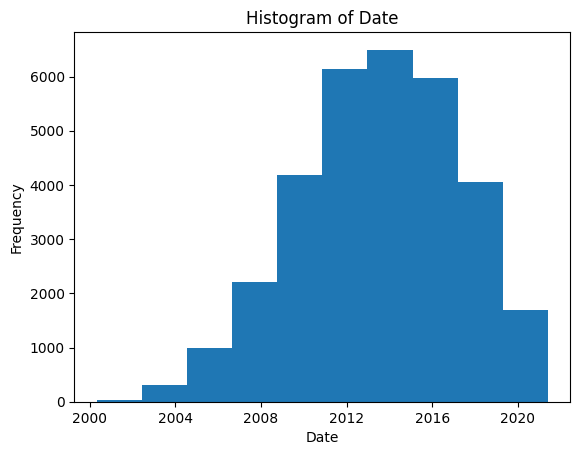

In [107]:
import matplotlib.pyplot as plt

# Assuming the dataframe is named 'df'
plt.hist(numeric_features['date'], bins=10)  # Adjust the number of bins as needed
plt.xlabel('Date')
plt.ylabel('Frequency')
plt.title('Histogram of Date')
plt.show()


In [108]:
#save the numeric features in a csv file
numeric_features.to_csv("Prostate_Cancer_TFM/Data_Analysis/EHRtemporalVariability/numeric_features_t2w_train.csv", index=False)

In [109]:
numeric_features[~(numeric_features['dep'] == '1')]

,instance,date,diagnostics_Image-original_Mean,diagnostics_Image-original_Minimum,diagnostics_Image-original_Maximum,diagnostics_Mask-original_VoxelNum,diagnostics_Mask-original_VolumeNum,diagnostics_Image-interpolated_Mean,diagnostics_Image-interpolated_Minimum,diagnostics_Image-interpolated_Maximum,...,original_glszm_ZonePercentage,original_glszm_ZoneVariance,original_ngtdm_Busyness,original_ngtdm_Coarseness,original_ngtdm_Complexity,original_ngtdm_Contrast,original_ngtdm_Strength,subject,session,dep
0,sub-003950_ses-006079_sub-003950_ses-006079_ac...,2014-06-28,225.311402,0.0,2909.0,5103360.0,1.0,0.753094,-0.932160,7.619302,...,0.000117,8.321105e+10,153158.296539,2.689853e-06,0.044203,0.008566,2.684532e-06,sub-003950,ses-006079,5.0
1,sub-003950_ses-006079_sub-003950_ses-006079_ac...,2014-06-28,200.321199,0.0,1603.0,6085200.0,1.0,0.310312,-1.336396,7.063852,...,0.000048,2.610029e+11,677216.977974,9.971449e-07,0.081039,0.019750,9.966209e-07,sub-003950,ses-006079,5.0
2,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1805.425141,0.0,8055.0,4597420.0,1.0,0.099533,-1.715879,4.728985,...,0.000679,2.049010e+09,160630.890944,5.877992e-06,0.121258,0.030303,5.877923e-06,sub-003950,ses-006328,5.0
3,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1822.788458,0.0,7239.0,5376756.0,1.0,-0.000049,-1.688143,3.891812,...,0.000552,2.600252e+09,219161.027152,6.558434e-06,0.102715,0.025420,6.557023e-06,sub-003950,ses-006328,5.0
4,sub-003950_ses-006328_sub-003950_ses-006328_ac...,2013-08-27,1558.584931,0.0,6253.0,4816728.0,1.0,0.097205,-1.570554,3.732276,...,0.000671,2.166652e+09,175687.427993,5.647307e-06,0.120539,0.030134,5.647317e-06,sub-003950,ses-006328,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32080,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,1542.441939,0.0,4979.0,6193536.0,1.0,0.000128,-2.038387,3.941289,...,0.000535,3.398477e+09,356651.604803,4.211401e-06,0.128513,0.031729,4.211509e-06,sub-003671,ses-006159,5.0
32081,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,1542.761783,0.0,5436.0,7693888.0,1.0,0.049647,-1.797537,3.769807,...,0.000658,3.530889e+09,259149.563737,3.988383e-06,0.106615,0.026650,3.988425e-06,sub-003671,ses-006159,5.0
32082,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,879.734623,0.0,7261.0,5713890.0,1.0,0.708992,-1.035303,5.334281,...,0.000193,7.940816e+10,217293.406147,1.815199e-06,0.043205,0.007976,1.814266e-06,sub-003671,ses-006159,5.0
32083,sub-003671_ses-006159_sub-003671_ses-006159_ac...,2013-12-02,1778.216492,0.0,6097.0,6030336.0,1.0,0.113093,-2.007433,3.544728,...,0.000366,5.614818e+09,171840.480838,4.417391e-06,0.110256,0.027262,4.416389e-06,sub-003671,ses-006159,5.0


In [110]:
numeric_features.columns

Index(['instance', 'date', 'diagnostics_Image-original_Mean',
       'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum',
       'diagnostics_Image-interpolated_Mean',
       'diagnostics_Image-interpolated_Minimum',
       'diagnostics_Image-interpolated_Maximum',
       ...
       'original_glszm_ZonePercentage', 'original_glszm_ZoneVariance',
       'original_ngtdm_Busyness', 'original_ngtdm_Coarseness',
       'original_ngtdm_Complexity', 'original_ngtdm_Contrast',
       'original_ngtdm_Strength', 'subject', 'session', 'dep'],
      dtype='object', length=125)

In [111]:
numeric_features['original_firstorder_Minimum']

0       -0.932160
1       -1.336396
2       -1.715879
3       -1.688143
4       -1.570554
           ...   
32080   -2.016750
32081   -1.788903
32082   -1.035303
32083   -2.007433
32084   -1.146992
Name: original_firstorder_Minimum, Length: 32085, dtype: float64

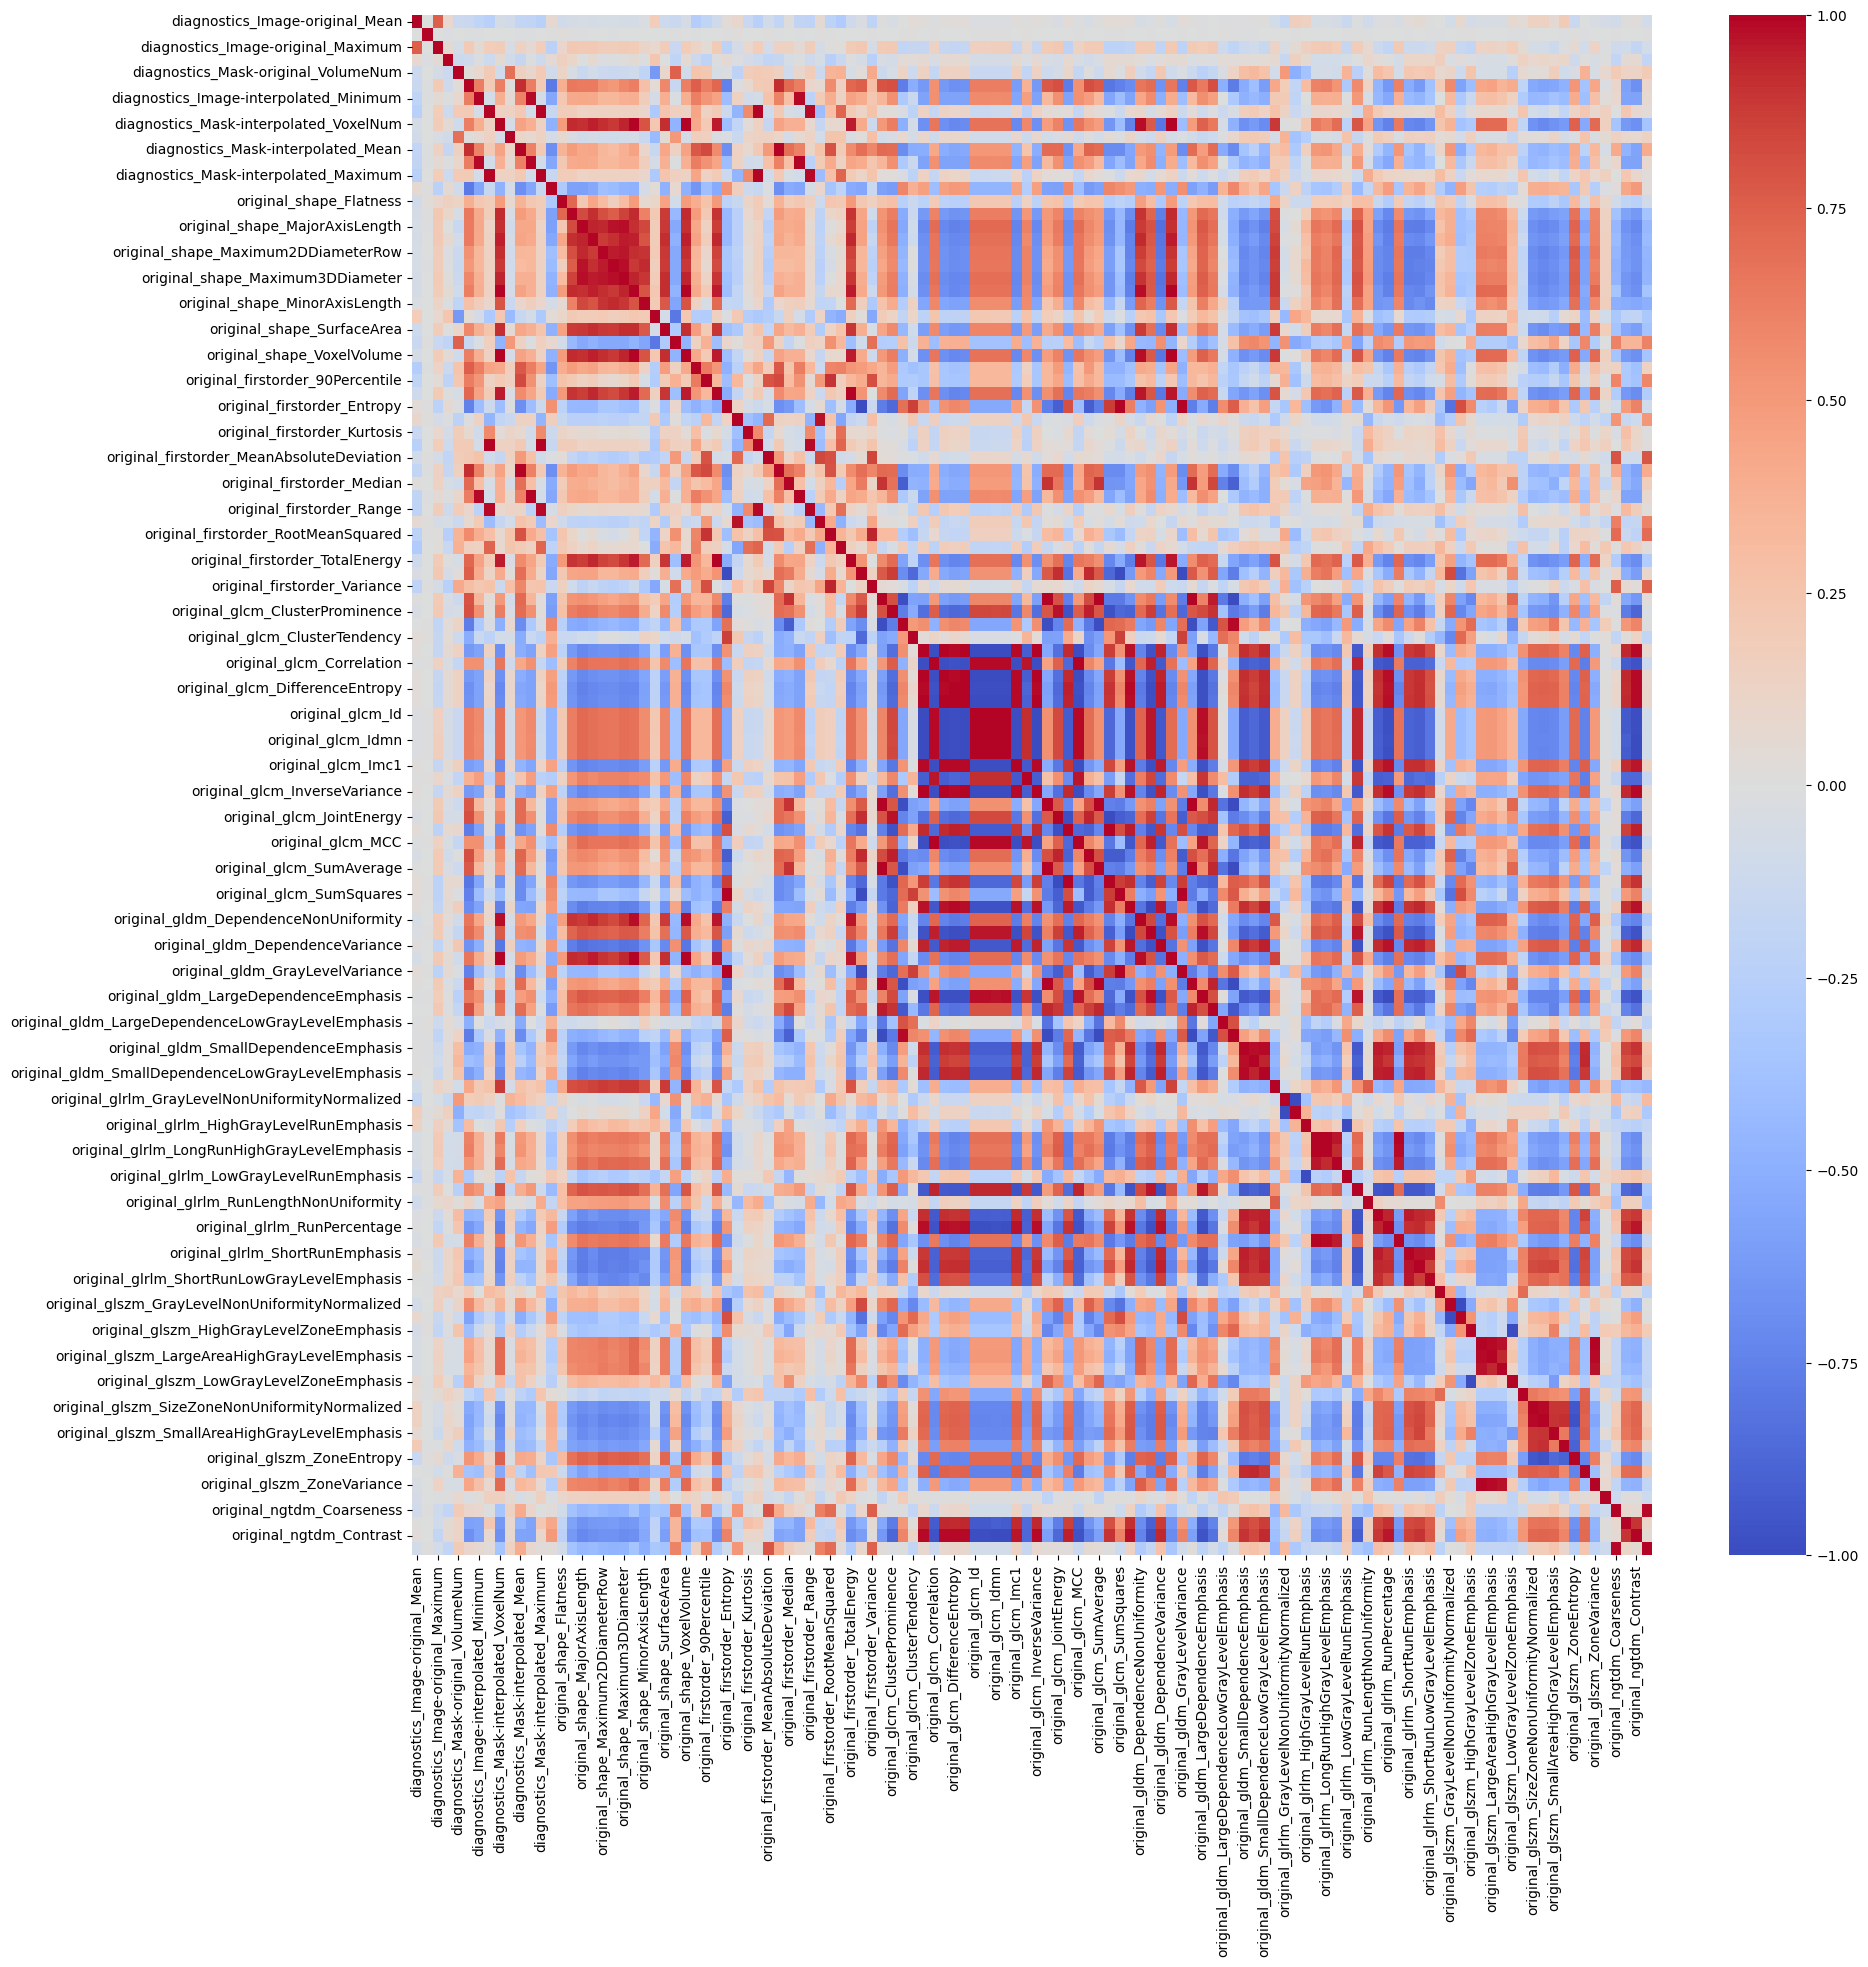

In [112]:
# Checking correlation between features
correlation = numeric_features.drop(columns=['instance', 'date','subject','session','dep']).corr()

# Plotting the correlation matrix
import seaborn as sns
plt.figure(figsize=(20, 20))
sns.heatmap(correlation, annot=False, cmap='coolwarm')
plt.show()


In [113]:
correlation[correlation['original_gldm_DependenceVariance']>0.8]['original_gldm_DependenceVariance']

original_glcm_Contrast                                0.942088
original_glcm_DifferenceAverage                       0.942088
original_glcm_DifferenceEntropy                       0.957412
original_glcm_DifferenceVariance                      0.953353
original_glcm_Imc1                                    0.955078
original_glcm_InverseVariance                         0.942088
original_glcm_JointEntropy                            0.894542
original_glcm_SumEntropy                              0.852153
original_gldm_DependenceEntropy                       0.961684
original_gldm_DependenceVariance                      1.000000
original_gldm_SmallDependenceEmphasis                 0.931804
original_gldm_SmallDependenceHighGrayLevelEmphasis    0.877667
original_gldm_SmallDependenceLowGrayLevelEmphasis     0.950283
original_glrlm_RunLengthNonUniformityNormalized       0.927109
original_glrlm_RunPercentage                          0.975204
original_glrlm_ShortRunEmphasis                       0

In [143]:
correlated_features = set()
correlation_matrix = correlation
highly_correlated = {}  # Dictionary to store highly correlated pairs

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            colname_i = correlation_matrix.columns[i]
            colname_j = correlation_matrix.columns[j]
            correlated_features.add(colname_i)
            correlated_features.add(colname_j)
            
            # Store the feature pair and their correlation
            highly_correlated[frozenset((colname_i, colname_j))] = correlation_matrix.iloc[i, j]

# Print each pair and their correlation
for pair, corr in highly_correlated.items():
    feature1, feature2 = pair
    print(f"{feature1} and {feature2} have a correlation of {corr}")

diagnostics_Mask-interpolated_Mean and diagnostics_Image-interpolated_Mean have a correlation of 0.915639449419039
diagnostics_Image-interpolated_Minimum and diagnostics_Mask-interpolated_Minimum have a correlation of 0.990178627525027
diagnostics_Mask-interpolated_Maximum and diagnostics_Image-interpolated_Maximum have a correlation of 0.9994424510374809
original_shape_LeastAxisLength and diagnostics_Mask-interpolated_VoxelNum have a correlation of 0.9250792599564516
original_shape_MajorAxisLength and diagnostics_Mask-interpolated_VoxelNum have a correlation of 0.9080539708910234
original_shape_Maximum2DDiameterColumn and diagnostics_Mask-interpolated_VoxelNum have a correlation of 0.9520152093123642
original_shape_Maximum2DDiameterColumn and original_shape_LeastAxisLength have a correlation of 0.9143187296703772
original_shape_Maximum2DDiameterColumn and original_shape_MajorAxisLength have a correlation of 0.9439408928807179
original_shape_Maximum2DDiameterRow and diagnostics_Mask-in

In [145]:
corr_matrix_var = numeric_features.drop(columns=['instance', 'date','subject','session','dep']).corr(
    method="spearman"
).abs()  # absolute correlation matrix

# Initialize the flag vector with True values
to_keep = np.full((corr_matrix_var.shape[1]), True, dtype=bool)

for i in range(corr_matrix_var.shape[1]):
    for j in range(i + 1, corr_matrix_var.shape[1]):
        if (
            to_keep[i]
            and corr_matrix_var.iloc[i, j] >= 0.9
        ):
            if to_keep[j]:
                to_keep[j] = False

In [150]:
list(numeric_features.drop(columns=['instance', 'date','subject','session','dep']).columns[to_keep])

['diagnostics_Image-original_Mean',
 'diagnostics_Image-original_Minimum',
 'diagnostics_Image-original_Maximum',
 'diagnostics_Mask-original_VoxelNum',
 'diagnostics_Mask-original_VolumeNum',
 'diagnostics_Image-interpolated_Mean',
 'diagnostics_Image-interpolated_Minimum',
 'diagnostics_Image-interpolated_Maximum',
 'diagnostics_Mask-interpolated_VoxelNum',
 'diagnostics_Mask-interpolated_Mean',
 'original_shape_Elongation',
 'original_shape_Flatness',
 'original_shape_LeastAxisLength',
 'original_shape_MinorAxisLength',
 'original_shape_Sphericity',
 'original_firstorder_10Percentile',
 'original_firstorder_90Percentile',
 'original_firstorder_Entropy',
 'original_firstorder_InterquartileRange',
 'original_firstorder_Kurtosis',
 'original_firstorder_MeanAbsoluteDeviation',
 'original_firstorder_Median',
 'original_firstorder_RootMeanSquared',
 'original_firstorder_Skewness',
 'original_firstorder_Variance',
 'original_glcm_ClusterProminence',
 'original_glcm_ClusterTendency',
 'orig

In [144]:
highly_correlated

{frozenset({'diagnostics_Image-interpolated_Mean',
            'diagnostics_Mask-interpolated_Mean'}): 0.915639449419039,
 frozenset({'diagnostics_Image-interpolated_Minimum',
            'diagnostics_Mask-interpolated_Minimum'}): 0.990178627525027,
 frozenset({'diagnostics_Image-interpolated_Maximum',
            'diagnostics_Mask-interpolated_Maximum'}): 0.9994424510374809,
 frozenset({'diagnostics_Mask-interpolated_VoxelNum',
            'original_shape_LeastAxisLength'}): 0.9250792599564516,
 frozenset({'diagnostics_Mask-interpolated_VoxelNum',
            'original_shape_MajorAxisLength'}): 0.9080539708910234,
 frozenset({'diagnostics_Mask-interpolated_VoxelNum',
            'original_shape_Maximum2DDiameterColumn'}): 0.9520152093123642,
 frozenset({'original_shape_LeastAxisLength',
            'original_shape_Maximum2DDiameterColumn'}): 0.9143187296703772,
 frozenset({'original_shape_MajorAxisLength',
            'original_shape_Maximum2DDiameterColumn'}): 0.9439408928807179,
 fr

In [27]:
highly_correlated

{frozenset({'diagnostics_Image-interpolated_Mean',
            'diagnostics_Mask-interpolated_Mean'}): 0.9143399007250262,
 frozenset({'diagnostics_Image-interpolated_Minimum',
            'diagnostics_Mask-interpolated_Minimum'}): 0.9900674205692611,
 frozenset({'diagnostics_Image-interpolated_Maximum',
            'diagnostics_Mask-interpolated_Maximum'}): 0.9993084379436381,
 frozenset({'diagnostics_Mask-interpolated_VoxelNum',
            'original_shape_LeastAxisLength'}): 0.9248463724907493,
 frozenset({'diagnostics_Mask-interpolated_VoxelNum',
            'original_shape_MajorAxisLength'}): 0.9090635153607911,
 frozenset({'original_shape_LeastAxisLength',
            'original_shape_MajorAxisLength'}): 0.8254784342858245,
 frozenset({'diagnostics_Mask-interpolated_VoxelNum',
            'original_shape_Maximum2DDiameterColumn'}): 0.9515978101638964,
 frozenset({'original_shape_LeastAxisLength',
            'original_shape_Maximum2DDiameterColumn'}): 0.9149025077677028,
 frozense

In [130]:
from sklearn.cluster import DBSCAN
import numpy as np

# Create a binary correlation matrix (1 if correlation > 0.8, 0 otherwise)
binary_corr_matrix = np.where(abs(correlation) > 0.9, 1, 0)

# Apply DBSCAN on the binary correlation matrix
db = DBSCAN(eps=0.5, min_samples=2).fit(binary_corr_matrix)

# Get the labels (cluster id for each feature)
labels = db.labels_

clusters = []
for cluster_id in set(labels):
    features_in_cluster = set(correlation.columns[np.where(labels == cluster_id)])
    clusters.append(features_in_cluster)

# Print the clusters and save first element of each cluster

final_features = []
all_features = []
for i, cluster in enumerate(clusters):
    print(f"Correalted Features {i}: {cluster}")
    final_features.append(list(cluster)[0])
    all_features.extend(list(cluster))


#

Correalted Features 0: {'diagnostics_Mask-interpolated_Mean', 'diagnostics_Image-interpolated_Mean', 'original_firstorder_Mean'}
Correalted Features 1: {'original_firstorder_Minimum', 'diagnostics_Image-interpolated_Minimum', 'diagnostics_Mask-interpolated_Minimum'}
Correalted Features 2: {'diagnostics_Mask-interpolated_Maximum', 'diagnostics_Image-interpolated_Maximum', 'original_firstorder_Maximum', 'original_firstorder_Range'}
Correalted Features 3: {'original_shape_VoxelVolume', 'original_shape_MeshVolume', 'diagnostics_Mask-interpolated_VoxelNum'}
Correalted Features 4: {'original_shape_LeastAxisLength', 'original_firstorder_TotalEnergy', 'original_firstorder_Energy'}
Correalted Features 5: {'original_gldm_GrayLevelVariance', 'original_glcm_SumSquares', 'original_firstorder_Entropy', 'original_firstorder_Uniformity'}
Correalted Features 6: {'original_firstorder_InterquartileRange', 'original_firstorder_RobustMeanAbsoluteDeviation'}
Correalted Features 7: {'original_firstorder_Root

In [142]:
correlation[abs(correlation['original_shape_MajorAxisLength'])>0.9]['original_shape_MajorAxisLength']

diagnostics_Mask-interpolated_VoxelNum    0.908054
original_shape_MajorAxisLength            1.000000
original_shape_Maximum2DDiameterColumn    0.943941
original_shape_Maximum2DDiameterRow       0.936751
original_shape_Maximum2DDiameterSlice     0.971954
original_shape_Maximum3DDiameter          0.982105
original_shape_MeshVolume                 0.908054
original_shape_VoxelVolume                0.908054
original_gldm_GrayLevelNonUniformity      0.907306
Name: original_shape_MajorAxisLength, dtype: float64

In [152]:
len(list(clusters[21]))

55

In [132]:
len(all_features)

120

In [133]:
len(correlation.columns)

120

In [128]:
final_features

['diagnostics_Mask-interpolated_Mean',
 'original_firstorder_Minimum',
 'diagnostics_Mask-interpolated_Maximum',
 'original_shape_VoxelVolume',
 'original_shape_LeastAxisLength',
 'original_gldm_GrayLevelVariance',
 'original_firstorder_InterquartileRange',
 'original_firstorder_RootMeanSquared',
 'original_gldm_HighGrayLevelEmphasis',
 'original_glcm_InverseVariance',
 'original_glcm_MCC',
 'original_gldm_DependenceEntropy',
 'original_glrlm_RunEntropy',
 'original_glrlm_GrayLevelNonUniformityNormalized',
 'original_glrlm_LowGrayLevelRunEmphasis',
 'original_glrlm_LongRunHighGrayLevelEmphasis',
 'original_glszm_GrayLevelNonUniformityNormalized',
 'original_glszm_HighGrayLevelZoneEmphasis',
 'original_glszm_LargeAreaHighGrayLevelEmphasis',
 'original_glszm_SizeZoneNonUniformityNormalized',
 'original_ngtdm_Coarseness',
 'original_glrlm_RunLengthNonUniformity']

In [129]:
correlation.columns

Index(['diagnostics_Image-original_Mean', 'diagnostics_Image-original_Minimum',
       'diagnostics_Image-original_Maximum',
       'diagnostics_Mask-original_VoxelNum',
       'diagnostics_Mask-original_VolumeNum',
       'diagnostics_Image-interpolated_Mean',
       'diagnostics_Image-interpolated_Minimum',
       'diagnostics_Image-interpolated_Maximum',
       'diagnostics_Mask-interpolated_VoxelNum',
       'diagnostics_Mask-interpolated_VolumeNum',
       ...
       'original_glszm_SmallAreaHighGrayLevelEmphasis',
       'original_glszm_SmallAreaLowGrayLevelEmphasis',
       'original_glszm_ZoneEntropy', 'original_glszm_ZonePercentage',
       'original_glszm_ZoneVariance', 'original_ngtdm_Busyness',
       'original_ngtdm_Coarseness', 'original_ngtdm_Complexity',
       'original_ngtdm_Contrast', 'original_ngtdm_Strength'],
      dtype='object', length=120)

In [33]:
import plotly.graph_objects as go
# Convert each set of features in clusters into a list
clusters_list = [list(cluster) for cluster in clusters]

fig = go.Figure(data=[go.Scatter3d(
    x=[feature[0] for feature in clusters_list],
    y=[feature[1] for feature in clusters_list],
    z=[feature[2] for feature in clusters_list],
    mode='markers',
    marker=dict(
        size=12,
        color=labels,                # set color to an array/list of desired values
        colorscale='Viridis',   # choose a colorscale
        opacity=0.8
    )
)])

fig.update_layout(margin=dict(l=0, r=0, b=0, t=0))
fig.show()

IndexError: list index out of range